In [1]:
import os
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point
import json
import matplotlib.pyplot as plt

import sesame as ssm

In [2]:
raw_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw/')
output_path = os.path.join(os.path.dirname(os.getcwd()),'data', 'output/')
plot_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'plot/')
netcdf_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'netcdf/')

# Pre-processing 

In [5]:
# Pre-porcess the raw data
# Read the Excel file, ensuring the first row is treated as data (not as column headers)
df = pd.read_excel(raw_path + "USGS_IronOre_PigIron_Steel.xlsx", sheet_name="raw_steel")

# # Add 'Y' in front of each column name if it's a year
# df.columns = ['Y' + str(col) if isinstance(col, int) or col.isdigit() else col for col in df.columns]

# Remove the last row
df = df.drop(df.index[-1])

# Reset the index if necessary
df = df.reset_index(drop=True)

# Optionally, convert the remaining data to the appropriate types
df = df.apply(pd.to_numeric, errors='ignore')
df

,Country,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,25.0,24.0,3.0,24.0,33.0,33.0,33.0,29.0,29.0,10.0
1,Albania,15.000,15.100,64.700,94.100,100.0,86.117,98.026,87.000,100.0,...,550.0,560.0,150.0,100.0,100.0,396.0,406.0,390.0,390.0,NaN
2,Algeria,400.000,758.000,842.000,850.000,1090.0,1051.000,1014.000,1007.000,1158.0,...,417.0,415.0,650.0,650.0,650.0,2300.0,2400.0,3000.0,3000.0,3500.0
3,Angola,9.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,4210.000,3797.000,4472.000,4107.075,4363.0,5033.200,5133.000,5386.000,5532.7,...,5186.0,5488.0,5028.0,4126.0,4600.0,5162.0,4645.0,3651.0,3651.0,5094.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Uzbekistan,344.000,343.000,420.000,460.000,450.0,472.000,602.166,607.253,730.0,...,746.0,751.0,643.0,654.0,654.0,646.0,666.0,939.0,939.0,950.0
102,Venezuela,3553.315,3261.365,3834.575,3812.700,4163.9,3930.099,4575.000,4907.000,4900.0,...,2139.0,1485.0,1345.0,553.0,553.0,129.0,50.0,29.0,29.0,27.0
103,Viet Nam,306.256,308.305,305.881,318.780,320.0,544.000,689.000,890.000,1400.0,...,3484.0,3954.0,4122.0,7811.0,11500.0,15471.0,17469.0,19900.0,19900.0,20004.0
104,Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91.0,91.0,52.0,45.0,54.0,210.0,220.0,200.0,200.0,200.0


In [6]:
df = ssm.add_iso3_column(df, "Country")
# Reshape the DataFrame
usgs_steel = df.melt(id_vars=['ISO3', "Country"], var_name='year', value_name='usgs_steel')
# convert thousand metric tons to tonnes
usgs_steel['usgs_steel'] = usgs_steel['usgs_steel'] * 1e3
# Ensure 'year' is in datetime format
usgs_steel['year'] = pd.to_datetime(usgs_steel['year'], format='%Y')
# Extract only the year
usgs_steel['year'] = usgs_steel['year'].dt.year
usgs_steel["source_usgs"] = "usgs"
usgs_steel

,ISO3,Country,year,usgs_steel,source_usgs
0,AFG,Afghanistan,1998,NaN,usgs
1,ALB,Albania,1998,15000.0,usgs
2,DZA,Algeria,1998,400000.0,usgs
3,AGO,Angola,1998,9000.0,usgs
4,ARG,Argentina,1998,4210000.0,usgs
...,...,...,...,...,...
2645,UZB,Uzbekistan,2022,950000.0,usgs
2646,VEN,Venezuela,2022,27000.0,usgs
2647,VNM,Viet Nam,2022,20004000.0,usgs
2648,ZMB,Zambia,2022,200000.0,usgs


In [7]:
# Assuming you've already loaded and cleaned the DataFrame as per your previous steps
df = pd.read_excel(raw_path + "WorldSteel_IronOre_CrudeSteel_PigIron.xlsx", sheet_name="crude_steel")
# Replace "Macedonia" with "North Macedonia" in the "Country" column
df['Country'] = df['Country'].replace('Macedonia', 'North Macedonia')
df = ssm.add_iso3_column(df, "Country")
# Reshape the DataFrame
wst_steel = df.melt(id_vars=['ISO3', "Country"], var_name='year', value_name='wst_steel')
# convert thousand metric tons to tonnes
wst_steel['wst_steel'] = wst_steel['wst_steel'] * 1e3
# Ensure 'year' is in datetime format
wst_steel['year'] = pd.to_datetime(wst_steel['year'], format='%Y')
# Extract only the year
wst_steel['year'] = wst_steel['year'].dt.year
wst_steel["source_wst"] = "wst"
wst_steel

,ISO3,Country,year,wst_steel,source_wst
0,AUT,Austria,1998,5282000.0,wst
1,BEL,Belgium,1998,11425000.0,wst
2,DNK,Denmark,1998,790000.0,wst
3,BGR,Bulgaria,1998,2242000.0,wst
4,HRV,Croatia,1998,101000.0,wst
...,...,...,...,...,...
2515,TWN,Taiwan,2021,23233000.0,wst
2516,THA,Thailand,2021,5473000.0,wst
2517,VNM,Viet Nam,2021,23019000.0,wst
2518,AUS,Australia,2021,5780000.0,wst


In [8]:
# British Geological Survey Data
# Load the data from the CSV file
df = pd.read_csv(raw_path + "filtered_iron_steel_data.csv")
df = df[df["erml_commodity"] == "Crude steel"]
df = df[df["bgs_statistic_type_trans"] == "Production"]
# Ensure 'year' is in datetime format
df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d')
# Extract only the year
df['year'] = df['year'].dt.year
df = ssm.add_iso3_column(df, "country_trans")
# Keep only the 'ISO3', "year, " and 'quantity' columns
bgs_steel = df.filter(items=['ISO3', 'country_trans', 'year', 'quantity'])
bgs_steel.rename({'quantity': 'bgs_steel'}, axis=1, inplace=True)
bgs_steel["source_bgs"] = "BGS"
bgs_steel

,ISO3,country_trans,year,bgs_steel,source_bgs
16,GTM,Guatemala,2000,167000.0,BGS
17,GTM,Guatemala,2001,202000.0,BGS
18,GTM,Guatemala,2002,216000.0,BGS
19,GTM,Guatemala,2003,226000.0,BGS
20,GTM,Guatemala,2004,232000.0,BGS
...,...,...,...,...,...
19228,SLV,El Salvador,2018,99000.0,BGS
19229,SLV,El Salvador,2019,102000.0,BGS
19230,SLV,El Salvador,2020,82000.0,BGS
19231,SLV,El Salvador,2021,103000.0,BGS


In [9]:
print(bgs_steel["bgs_steel"].sum())
print(wst_steel["wst_steel"].sum())
print(usgs_steel["usgs_steel"].sum())

54503000868.0
32937830000.0
34532363052.0


In [10]:
# Perform outer merges to include all ISO3 codes
merged_df = bgs_steel.merge(usgs_steel, on=['ISO3', 'year'], how='outer')\
                    .merge(wst_steel, on=['ISO3', 'year'], how='outer')
merged_df

,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst
0,AFG,NaN,1998,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN
1,AFG,NaN,1999,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN
2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN
3,AFG,NaN,2001,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN
4,AFG,NaN,2002,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4634,ZWE,Zimbabwe,2018,1322.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst
4635,ZWE,Zimbabwe,2019,3583.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst
4636,ZWE,Zimbabwe,2020,5196.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst
4637,ZWE,Zimbabwe,2021,3921.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst


In [11]:
print(merged_df["bgs_steel"].sum())
print(merged_df["wst_steel"].sum())
print(merged_df["usgs_steel"].sum())

54503000868.0
32937830000.0
34532363052.0


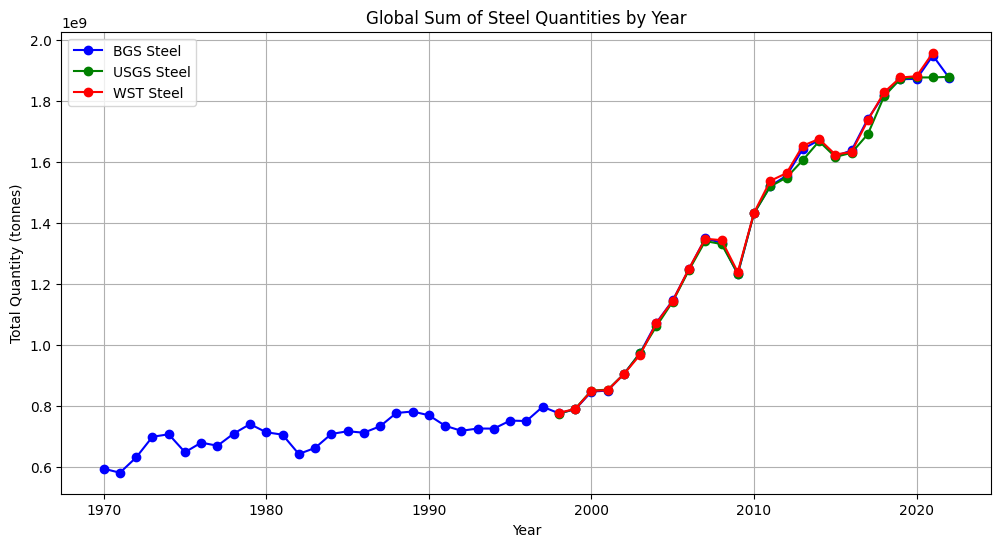

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded and contains the correct columns
# Convert 'year' to datetime format
merged_df['year'] = pd.to_datetime(merged_df['year'], format='%Y')

# Group by 'year' and sum the quantities for each steel source, keeping NaNs
global_sums = merged_df.groupby(merged_df['year'].dt.year).agg({
    'bgs_steel': 'sum',
    'usgs_steel': 'sum',
    'wst_steel': 'sum'
}).reset_index()

# Replace 0 with np.nan to avoid plotting zeros
global_sums.replace(0, np.nan, inplace=True)

# Plotting the time series, NaNs will result in gaps
plt.figure(figsize=(12, 6))
plt.plot(global_sums['year'], global_sums['bgs_steel'], label='BGS Steel', color='blue', marker='o')
plt.plot(global_sums['year'], global_sums['usgs_steel'], label='USGS Steel', color='green', marker='o')
plt.plot(global_sums['year'], global_sums['wst_steel'], label='WST Steel', color='red', marker='o')

# Adding titles and labels
plt.title('Global Sum of Steel Quantities by Year')
plt.xlabel('Year')
plt.ylabel('Total Quantity (tonnes)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [14]:
import pandas as pd
import numpy as np

# Assume merged_df is your existing DataFrame

# Initialize new columns for combined steel data and source tracking
merged_df['steel_com'] = np.nan
merged_df['source'] = ''

# Define a function to combine steel data based on specified rules
def combine_steel(row):
    values = {}
    
    # Collect available data, converting 0s to NaN to avoid division by zero
    if not pd.isna(row['bgs_steel']) and row['bgs_steel'] != 0:
        values['BGS'] = row['bgs_steel']
    if not pd.isna(row['wst_steel']) and row['wst_steel'] != 0:
        values['WST'] = row['wst_steel']
    if not pd.isna(row['usgs_steel']) and row['usgs_steel'] != 0:
        values['USGS'] = row['usgs_steel']
    
    # If only one source is available, use it directly
    if len(values) == 1:
        source, value = next(iter(values.items()))
        row['steel_com'] = value
        row['source'] = source
        return row
    
    # Calculate discrepancies between sources
    discrepancies = {}
    if 'BGS' in values and 'WST' in values:
        discrepancies['BGS, WST'] = abs(values['BGS'] - values['WST']) / values['BGS']
    if 'BGS' in values and 'USGS' in values:
        discrepancies['BGS, USGS'] = abs(values['BGS'] - values['USGS']) / values['BGS']
    if 'WST' in values and 'USGS' in values:
        discrepancies['WST, USGS'] = abs(values['WST'] - values['USGS']) / values['WST']
    
    # Filter pairs with discrepancy <= 5%
    closest_pair = {k: v for k, v in discrepancies.items() if v <= 0.05}
    
    if closest_pair:
        # Select the closest pair with the smallest discrepancy
        closest_pair_key = min(closest_pair, key=closest_pair.get)
        closest_sources = closest_pair_key.split(', ')
        closest_values = [values[source] for source in closest_sources]
        row['steel_com'] = np.mean(closest_values)
        row['source'] = ', '.join(closest_sources)
    else:
        # If no pairs are close enough, take the average of all available sources
        if values:
            row['steel_com'] = np.mean(list(values.values()))
            row['source'] = ', '.join(values.keys())
    
    return row

# Apply the function to each row in the DataFrame
merged_df = merged_df.apply(combine_steel, axis=1)

# Display the DataFrame with the new combined steel data and source columns
merged_df


,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source
0,AFG,NaN,1998-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
1,AFG,NaN,1999-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
2,AFG,NaN,2000-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
3,AFG,NaN,2001-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
4,AFG,NaN,2002-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4634,ZWE,Zimbabwe,2018-01-01,1322.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,1322.0,BGS
4635,ZWE,Zimbabwe,2019-01-01,3583.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3583.0,BGS
4636,ZWE,Zimbabwe,2020-01-01,5196.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,5196.0,BGS
4637,ZWE,Zimbabwe,2021-01-01,3921.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3921.0,BGS


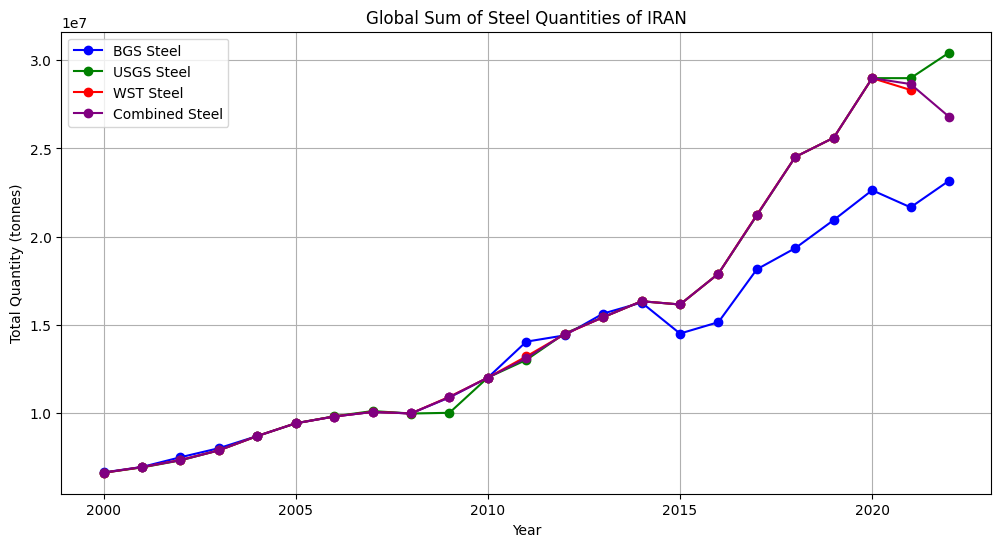

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded and contains the correct columns
# Convert 'year' to datetime format if not already done
merged_df['year'] = pd.to_datetime(merged_df['year'], format='%Y')

merged_irn = merged_df[merged_df["ISO3"] == "IRN"]
merged_irn = merged_irn[merged_df["year"] >= "2000"]

# Group by 'year' and sum the quantities for each steel source, including 'steel_com'
global_sums = merged_irn.groupby(merged_df['year'].dt.year).agg({
    'bgs_steel': 'sum',
    'usgs_steel': 'sum',
    'wst_steel': 'sum',
    'steel_com': 'sum'
}).reset_index()

# Replace 0 with np.nan to avoid plotting zeros
global_sums.replace(0, np.nan, inplace=True)

# Plotting the time series, NaNs will result in gaps
plt.figure(figsize=(12, 6))
plt.plot(global_sums['year'], global_sums['bgs_steel'], label='BGS Steel', color='blue', marker='o')
plt.plot(global_sums['year'], global_sums['usgs_steel'], label='USGS Steel', color='green', marker='o')
plt.plot(global_sums['year'], global_sums['wst_steel'], label='WST Steel', color='red', marker='o')
plt.plot(global_sums['year'], global_sums['steel_com'], label='Combined Steel', color='purple', marker='o')

# Adding titles and labels
plt.title('Global Sum of Steel Quantities of IRAN')
plt.xlabel('Year')
plt.ylabel('Total Quantity (tonnes)')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [16]:
# since WST is not available for IRN but by understanding the trend, we find that the production increased from 2021 to 2021 from BGS and USGS.
# till 2021, two close productions WST and USGS were considered and therefore, we manually replaced the 2022 data using the USGS data

# Replace 'steel_com' and 'source' for the specific row where ISO3 == 'IRN' and year == 2022
condition = (merged_df['ISO3'] == 'IRN') & (merged_df['year'] == '2022-01-01')

# Update the 'steel_com' value to the 'usgs_steel' value
merged_df.loc[condition, 'steel_com'] = merged_df.loc[condition, 'usgs_steel']

# Update the 'source' to 'USGS'
merged_df.loc[condition, 'source'] = 'USGS'

merged_df

,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source
0,AFG,NaN,1998-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
1,AFG,NaN,1999-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
2,AFG,NaN,2000-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
3,AFG,NaN,2001-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
4,AFG,NaN,2002-01-01,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4634,ZWE,Zimbabwe,2018-01-01,1322.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,1322.0,BGS
4635,ZWE,Zimbabwe,2019-01-01,3583.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3583.0,BGS
4636,ZWE,Zimbabwe,2020-01-01,5196.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,5196.0,BGS
4637,ZWE,Zimbabwe,2021-01-01,3921.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3921.0,BGS


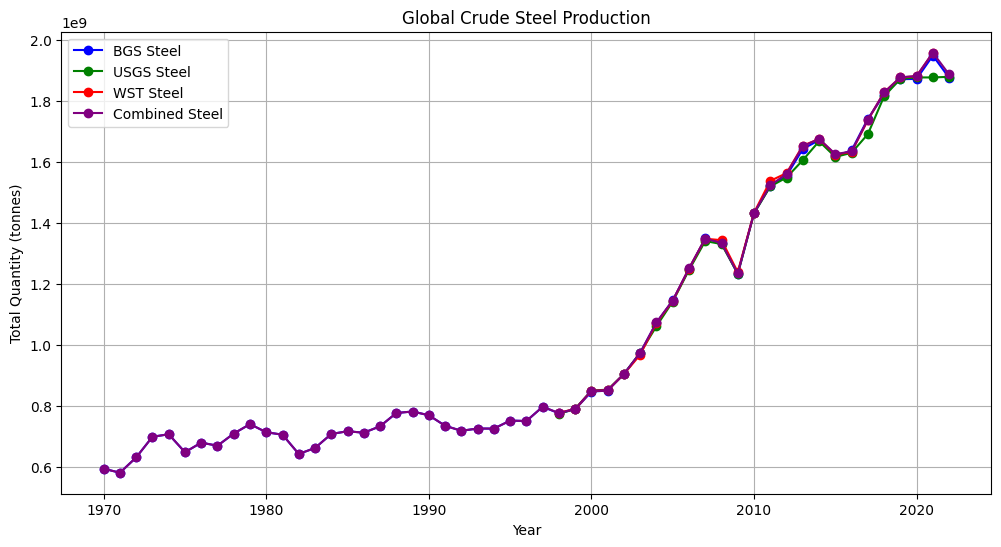

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded and contains the correct columns
# Convert 'year' to datetime format if not already done
merged_df['year'] = pd.to_datetime(merged_df['year'], format='%Y')

# Group by 'year' and sum the quantities for each steel source, including 'steel_com'
global_sums = merged_df.groupby(merged_df['year'].dt.year).agg({
    'bgs_steel': 'sum',
    'usgs_steel': 'sum',
    'wst_steel': 'sum',
    'steel_com': 'sum'
}).reset_index()

# Replace 0 with np.nan to avoid plotting zeros
global_sums.replace(0, np.nan, inplace=True)

# Plotting the time series, NaNs will result in gaps
plt.figure(figsize=(12, 6))
plt.plot(global_sums['year'], global_sums['bgs_steel'], label='BGS Steel', color='blue', marker='o')
plt.plot(global_sums['year'], global_sums['usgs_steel'], label='USGS Steel', color='green', marker='o')
plt.plot(global_sums['year'], global_sums['wst_steel'], label='WST Steel', color='red', marker='o')
plt.plot(global_sums['year'], global_sums['steel_com'], label='Combined Steel', color='purple', marker='o')

# Adding titles and labels
plt.title('Global Crude Steel Production')
plt.xlabel('Year')
plt.ylabel('Total Quantity (tonnes)')
plt.grid(True)
plt.legend()
plt.savefig(plot_path + "global_steel_production.pdf", dpi=600)
# Show the plot
plt.show()


In [19]:
merged_df.to_csv(output_path + "crude_steel_merged.csv")

# Surrogate Variable

In [21]:
# Read the Excel file, ensuring the first row is treated as data (not as column headers)
df = pd.read_excel(raw_path + "Global-Steel-Plant-Tracker-April-2024-Standard-Copy-V1.xlsx", sheet_name="Steel Plants")
# Replace all "unknown" values with NaN in the entire dataframe
df.replace("unknown", np.nan, inplace=True)
df.replace("N/A", np.nan, inplace=True)
# Ensure the 'Retired Date' column is in datetime format
df['Retired Date'] = pd.to_datetime(df['Retired Date'], errors='coerce')
# Filter and drop rows where 'Capacity operating status' is 'retired' and 'Retired Date' is before 2000
df = df.drop(df[(df['Capacity operating status'] == 'retired') & (df['Retired Date'].dt.year < 2000)].index)
df

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
1,P100000120753,Abba Steel Ohangwena steel plant,NaN,Groot Suisse Oshana plant,NaN,Abba Steel Ltd.,NaN,E100001012072,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,EAF (# unknown),NaN,NaN,NaN
2,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
3,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),Waste Heat Power Generation,NaN,NaN
1844,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),NaN,NaN,NaN
1845,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 75*2电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,NaN,Yes,NaN,NaN,electric,EAF,2 EAF (2x75-tonne),State Grid,NaN,NaN
1846,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 100电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,NaN,Yes,NaN,NaN,electric,EAF,"2 EAF (1x100-tonne, 1x50-tonne)",State Grid,NaN,NaN


In [22]:
# Define the values to drop
status_to_drop = ['construction', 'cancelled', 'announced']

# Filter out rows where 'Capacity operating status' is in the list
df = df.drop(df[df['Capacity operating status'].isin(status_to_drop)].index)
df

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
2,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
3,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
5,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,P100000120821,Zlatoust Metallurgical Plant,Златоустовский металлургический завод (Russian),ZMK; ZMZ; Zlatoust Steel Works; Zlatoust Steel...,NaN,ZLATOUST IRON AND STEEL WORKS JOINT STOCK COMPANY,NaN,E100000130764,4.296075e+09,NaN,...,2700,NaN,NaN,NaN,electric,EAF,2 EAF (EAFs were planned to be modernized in 2...,The plant has several mini boiler stations,NaN,NaN
1842,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,133,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),Waste Heat Power Generation,NaN,NaN
1844,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),NaN,NaN,NaN
1845,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 75*2电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,NaN,Yes,NaN,NaN,electric,EAF,2 EAF (2x75-tonne),State Grid,NaN,NaN


In [23]:
# Convert 'Start date' to datetime, replacing invalid values with NaT
# Convert 'Retired Date' to datetime, replacing invalid values with NaT
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df['Retired Date'] = pd.to_datetime(df['Retired Date'], errors='coerce')

# Replace remaining NaT in 'Start date' with 2000, and in 'Retired Date' with 2022
df['Start date'].fillna(pd.Timestamp(2000, 1, 1), inplace=True)
df['Retired Date'].fillna(pd.Timestamp(2022, 1, 1), inplace=True)

# Store only the year in the 'Start date' and 'Retired Date' columns
df['Start date'] = df['Start date'].dt.year
df['Retired Date'] = df['Retired Date'].dt.year
df

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
2,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
3,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
5,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,P100000120821,Zlatoust Metallurgical Plant,Златоустовский металлургический завод (Russian),ZMK; ZMZ; Zlatoust Steel Works; Zlatoust Steel...,NaN,ZLATOUST IRON AND STEEL WORKS JOINT STOCK COMPANY,NaN,E100000130764,4.296075e+09,NaN,...,2700,NaN,NaN,NaN,electric,EAF,2 EAF (EAFs were planned to be modernized in 2...,The plant has several mini boiler stations,NaN,NaN
1842,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,133,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),Waste Heat Power Generation,NaN,NaN
1844,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),NaN,NaN,NaN
1845,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 75*2电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,NaN,Yes,NaN,NaN,electric,EAF,2 EAF (2x75-tonne),State Grid,NaN,NaN


In [24]:
# Define the coordinates to add
coordinates_y = 41.28578865340147
coordinates_x = 123.78599360076812

# Update the missing coordinates for the specific plant
df.loc[df['Plant name (English)'] == 'Benxi Beiying Iron & Steel (Group) Co Ltd', 'Coordinates_X'] = coordinates_x
df.loc[df['Plant name (English)'] == 'Benxi Beiying Iron & Steel (Group) Co Ltd', 'Coordinates_Y'] = coordinates_y

In [25]:
def fill_missing_capacity(df, country_col='Country/Area', capacity_col='Nominal crude steel capacity (ttpa)'):
    # Calculate the average capacity for each country
    country_avg = df.groupby(country_col)[capacity_col].transform('mean')
    
    # Calculate the overall average capacity
    overall_avg = df[capacity_col].mean()
    
    # Fill NaN values with the country average if available, otherwise with the overall average
    df[capacity_col] = df[capacity_col].fillna(country_avg).fillna(overall_avg)
    
    return df

df_filled = fill_missing_capacity(df)
df_filled

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
2,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
3,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
5,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,P100000120821,Zlatoust Metallurgical Plant,Златоустовский металлургический завод (Russian),ZMK; ZMZ; Zlatoust Steel Works; Zlatoust Steel...,NaN,ZLATOUST IRON AND STEEL WORKS JOINT STOCK COMPANY,NaN,E100000130764,4.296075e+09,NaN,...,2700,NaN,NaN,NaN,electric,EAF,2 EAF (EAFs were planned to be modernized in 2...,The plant has several mini boiler stations,NaN,NaN
1842,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,133,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),Waste Heat Power Generation,NaN,NaN
1844,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),NaN,NaN,NaN
1845,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 75*2电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,NaN,Yes,NaN,NaN,electric,EAF,2 EAF (2x75-tonne),State Grid,NaN,NaN


In [26]:
df = ssm.add_iso3_column(df_filled, "Country/Area")
df

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source,ISO3
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN,TUR
2,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN,RUS
3,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN,BGD
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN,ITA
5,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN,ITA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,P100000120821,Zlatoust Metallurgical Plant,Златоустовский металлургический завод (Russian),ZMK; ZMZ; Zlatoust Steel Works; Zlatoust Steel...,NaN,ZLATOUST IRON AND STEEL WORKS JOINT STOCK COMPANY,NaN,E100000130764,4.296075e+09,NaN,...,NaN,NaN,NaN,electric,EAF,2 EAF (EAFs were planned to be modernized in 2...,The plant has several mini boiler stations,NaN,NaN,RUS
1842,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),Waste Heat Power Generation,NaN,NaN,CHN
1844,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),NaN,NaN,NaN,CHN
1845,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 75*2电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,Yes,NaN,NaN,electric,EAF,2 EAF (2x75-tonne),State Grid,NaN,NaN,CHN


In [27]:
df['Start date'].unique()

array([1983, 2014, 2015, 1965, 1979, 1991, 2000, 1966, 1970, 2018, 1987,
       2021, 1976, 1969, 1994, 2012, 2019, 2023, 1943, 1989, 2004, 1986,
       1896, 1955, 1998, 2017, 1901, 2003, 1944, 2011, 1942, 2001, 1916,
       2006, 2010, 2022, 2008, 2002, 2007, 1961, 1980, 1958, 2005, 1949,
       1946, 1950, 1971, 1937, 1957, 1912, 1852, 1911, 1906, 1884, 1984,
       1954, 1934, 1925, 1974, 1914, 1997, 1992, 2016, 2009, 1902, 1947,
       1892, 1771, 1973, 1900, 1999, 2013, 1977, 1951, 1996, 1928, 1864,
       1995, 1968, 1899, 1813, 1956, 1993, 1929, 1959, 1964, 1908, 1913,
       1810, 1920, 1924, 1917, 1866, 2020, 1982, 1878, 1990, 1962, 1887,
       1927, 1905, 1972, 1940, 1881, 1932, 1953, 1952, 1941, 2024, 1978,
       1948, 1963, 1909, 1935, 1967, 1975, 1985, 1865, 1939, 1938, 1889,
       1930, 1875, 1897, 1933, 1894, 1981, 1904, 1988, 1796, 1960, 1886,
       1895, 1872, 1873, 1918, 1858, 2025, 1891, 1739, 1898, 1919],
      dtype=int32)

In [29]:
df_steel = pd.read_csv(output_path + "crude_steel_merged.csv")
df_steel['year'] = pd.to_datetime(df_steel['year'], errors='coerce')
df_steel = df_steel[(df_steel['year'].dt.year >= 2000) & (df_steel['year'].dt.year <= 2022)]
df_steel['year'] = df_steel['year'].dt.year
unique_year = df_steel["year"].unique()
unique_year


array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022], dtype=int32)

In [30]:
df_dates = df
unique_year = df_steel["year"].unique()

# Initialize a list to store missing ISO3 records
missing_records = []

for year in unique_year:
    
    # Filter out rows with missing 'steel_com'
    df_steel_filtered = df_steel[df_steel["steel_com"].notna()]
    
    # Filter df_steel for the current year
    df_st = df_steel_filtered[df_steel_filtered["year"] == year]

    # Filter df_dates where the year is between 'Start date' and 'Retired Date'
    filtered_df_dates = df_dates[
        (df_dates['Start date'] <= year) &
        (df_dates['Retired Date'] >= year)
    ]
    
    # Get unique ISO3 from the filtered df_dates
    unique_iso3_dates = filtered_df_dates['ISO3'].unique()
    
    # Get unique ISO3 from df_st for the current year
    unique_iso3_st = df_st['ISO3'].unique()
    
    # Find ISO3 that are missing in df_st for the current year
    missing_iso3 = set(unique_iso3_st) - set(unique_iso3_dates)
    
    for iso3 in missing_iso3:
        missing_records.append({'Year': year, 'ISO3': iso3})
    print(missing_iso3)


# Convert the list of missing records to a DataFrame
df_missing = pd.DataFrame(missing_records)

{'ECU', 'DNK', 'PRY', 'SYR', 'ZWE', 'COL', 'MRT', 'URY', 'CUB', 'SLV', 'DOM', 'LKA', 'TUN', 'KEN', 'GHA', 'HKG', 'HRV', 'ISR', 'MNG', 'JOR', 'IRL', 'GEO', 'COD', 'SCG', 'EST', 'MMR'}
{'ECU', 'DNK', 'PRY', 'SYR', 'ZWE', 'COL', 'MRT', 'URY', 'CUB', 'SLV', 'DOM', 'LKA', 'TUN', 'KEN', 'GHA', 'HKG', 'HRV', 'ISR', 'MNG', 'JOR', 'IRL', 'GEO', 'COD', 'SCG', 'EST', 'MMR'}
{'ECU', 'DNK', 'PRY', 'SYR', 'ZWE', 'COL', 'MRT', 'URY', 'CUB', 'SLV', 'DOM', 'LKA', 'TUN', 'KEN', 'GHA', 'HKG', 'HRV', 'ISR', 'MNG', 'JOR', 'GEO', 'COD', 'SCG', 'EST', 'MMR'}
{'ECU', 'PRY', 'SYR', 'ZWE', 'COL', 'MRT', 'URY', 'CUB', 'SLV', 'DOM', 'LKA', 'TUN', 'KEN', 'GHA', 'HKG', 'HRV', 'ISR', 'KWT', 'MNG', 'JOR', 'ETH', 'COD', 'SCG', 'EST', 'MMR'}
{'ECU', 'PRY', 'SYR', 'ZWE', 'COL', 'MRT', 'URY', 'CUB', 'SLV', 'DOM', 'LKA', 'TUN', 'KEN', 'GHA', 'HKG', 'HRV', 'ISR', 'KWT', 'MNG', 'JOR', 'ETH', 'COD', 'SCG', 'MMR'}
{'ECU', 'PRY', 'SYR', 'ZWE', 'COL', 'MRT', 'URY', 'CUB', 'SLV', 'DOM', 'LKA', 'TUN', 'KEN', 'GHA', 'HKG', 'HRV', 

## Comments
- Many countries are missing steel plant location data.
- We manually identified plants using Google Maps by searching for iron and steel facilities.
- Let’s repeat the process to add the missing plant locations.

In [31]:
# Read the Excel file, ensuring the first row is treated as data (not as column headers)
df = pd.read_excel(raw_path + "Global-Steel-Plant-Tracker-April-2024-Standard-Copy-V1.xlsx", sheet_name="Steel Plants")
# Replace all "unknown" values with NaN in the entire dataframe
df.replace("unknown", np.nan, inplace=True)
df.replace("N/A", np.nan, inplace=True)
# Ensure the 'Retired Date' column is in datetime format
df['Retired Date'] = pd.to_datetime(df['Retired Date'], errors='coerce')
# Filter and drop rows where 'Capacity operating status' is 'retired' and 'Retired Date' is before 2000
df = df.drop(df[(df['Capacity operating status'] == 'retired') & (df['Retired Date'].dt.year < 2000)].index)
# Define the values to drop
status_to_drop = ['construction', 'cancelled', 'announced']
# Filter out rows where 'Capacity operating status' is in the list
df = df.drop(df[df['Capacity operating status'].isin(status_to_drop)].index)
df

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
2,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
3,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
5,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1840,P100000120821,Zlatoust Metallurgical Plant,Златоустовский металлургический завод (Russian),ZMK; ZMZ; Zlatoust Steel Works; Zlatoust Steel...,NaN,ZLATOUST IRON AND STEEL WORKS JOINT STOCK COMPANY,NaN,E100000130764,4.296075e+09,NaN,...,2700,NaN,NaN,NaN,electric,EAF,2 EAF (EAFs were planned to be modernized in 2...,The plant has several mini boiler stations,NaN,NaN
1842,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,133,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),Waste Heat Power Generation,NaN,NaN
1844,P100000120403,Zunyi Changling Special Steel Co Ltd,遵义长岭特殊钢有限公司 110电炉,NaN,NaN,"Zunyi Changling Special Steel Co., Ltd.",遵义长岭特殊钢有限公司,E100000127332,NaN,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF (1x110-tonne),NaN,NaN,NaN
1845,P100000120359,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司 75*2电炉,NaN,NaN,Zunyi Fuxin Special Steel Equipment Manufactur...,遵义福鑫特殊钢装备制造有限公司,E100000126901,NaN,NaN,...,NaN,Yes,NaN,NaN,electric,EAF,2 EAF (2x75-tonne),State Grid,NaN,NaN


In [32]:
df_missing = pd.read_csv(raw_path + "missing_steel_plants.csv", encoding='ISO-8859-1')
df_missing

,Plant name (English),Coordinates_Y,Coordinates_X
0,Mainsten Ltd.,59.462029,24.678785
1,FREEN OÜ,59.409473,27.261922
2,,59.387433,24.400053
3,Rapla Metall OÜ,59.024876,24.767084
4,Ironweld,58.395192,24.631944
...,...,...,...
92,,-25.090265,-57.512192
93,,-34.810240,-56.100267
94,Myingyan No. 1 Steel Mill,21.376416,95.374864
95,Master Steel Ltd,-1.978489,30.099187


In [33]:
# Concatenate df and df_missing
df = pd.concat([df, df_missing], ignore_index=True)
df

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
1,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
2,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
3,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1431,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,NaN,Myingyan No. 1 Steel Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,Master Steel Ltd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Convert 'Start date' to datetime, replacing invalid values with NaT
# Convert 'Retired Date' to datetime, replacing invalid values with NaT
df['Start date'] = pd.to_datetime(df['Start date'], errors='coerce')
df['Retired Date'] = pd.to_datetime(df['Retired Date'], errors='coerce')

# Replace remaining NaT in 'Start date' with 2000, and in 'Retired Date' with 2022
df['Start date'].fillna(pd.Timestamp(2000, 1, 1), inplace=True)
df['Retired Date'].fillna(pd.Timestamp(2022, 1, 1), inplace=True)

# Store only the year in the 'Start date' and 'Retired Date' columns
df['Start date'] = df['Start date'].dt.year
df['Retired Date'] = df['Retired Date'].dt.year

# Define the coordinates to add
coordinates_y = 41.28578865340147
coordinates_x = 123.78599360076812

# Update the missing coordinates for the specific plant
df.loc[df['Plant name (English)'] == 'Benxi Beiying Iron & Steel (Group) Co Ltd', 'Coordinates_X'] = coordinates_x
df.loc[df['Plant name (English)'] == 'Benxi Beiying Iron & Steel (Group) Co Ltd', 'Coordinates_Y'] = coordinates_y


In [35]:
def fill_missing_capacity(df, country_col='Country/Area', capacity_col='Nominal crude steel capacity (ttpa)'):
    # Calculate the average capacity for each country
    country_avg = df.groupby(country_col)[capacity_col].transform('mean')
    
    # Calculate the overall average capacity
    overall_avg = df[capacity_col].mean()
    
    # Fill NaN values with the country average if available, otherwise with a random number as their capacity will be assumued as equal
    df[capacity_col] = df[capacity_col].fillna(country_avg).fillna(500)
    
    return df

df_filled = fill_missing_capacity(df)
df_filled

,Plant ID,Plant name (English),Plant name (other language),Other plant names (English),Other plant names (other language),Owner,Owner (other language),Owner GEM ID,Owner PermID,SOE Status,...,Workforce size,ISO 14001,ISO 50001,ResponsibleSteel Certification,Main production process,Main production equipment,Detailed production equipment,Power source,Iron ore source,Met coal source
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",NaN,ABA Çelik Demir AŞ,NaN,E100000131190,NaN,NaN,...,900,NaN,NaN,NaN,electric,EAF,1 EAF (110-tonne),NaN,NaN,NaN
1,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,NaN,Abinski Elektrometallurgicheski Zavod OOO,NaN,E100000130999,5.039667e+09,NaN,...,4101,2022,NaN,NaN,electric,EAF,1 EAF (130-tonne),NaN,NaN,NaN
2,P100000120020,Abul Khair Steel Sitakunda plant,NaN,AKS Sitakund; AKS Long Steel; AKS Melting,NaN,Abul Khair Steel Ltd,NaN,E100000131068,5.074007e+09,NaN,...,NaN,NaN,NaN,NaN,electric,EAF,1 EAF,NaN,NaN,NaN
3,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
4,P100000120620,Acciaierie d'Italia Taranto steel plant,NaN,ILVA Taranto steel plant (predecessor); ILVA S...,NaN,Acciaierie d'italia SpA,NaN,E100001010116,5.067495e+09,Partial,...,11000,2022,2022,NaN,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1431,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,NaN,Myingyan No. 1 Steel Mill,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1433,NaN,Master Steel Ltd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

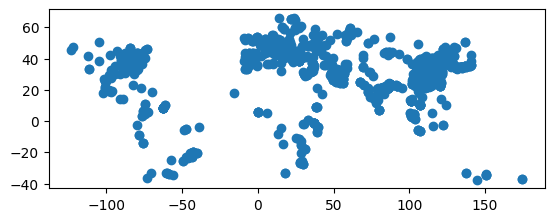

In [36]:
# Create geometry using the lat, lon
geometry = [Point(xy) for xy in zip(df_filled['Coordinates_X'], df_filled['Coordinates_Y'])]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_filled, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Save the GeoDataFrame as a shapefile
gdf.to_file(output_path + "combined_steel_plants.shp")

gdf.plot()

In [38]:
years = list(range(2000, 2023, 1))

source = (
    "Worldwide: Global Energy Monitor, Global Steel Plant Tracker, April 2024 (V1) release.\n"
    "Missing Countries: Manual Google Search from multiple sources."
)
dataset_list = []

for year in years:
    # Filter df_dates where the year is between 'Start date' and 'Retired Date'
    filtered_gdf = gdf[
    (gdf['Start date'] <= year) & 
    (gdf['Retired Date'] >= year)
        ].copy()  # Make an explicit copy
    
    time_str = f"{year}-01-01"
    ds_st = ssm.point_2_grid(point_data=filtered_gdf, variable_name="steel_plants_capacity", long_name="Steel Plants Capacity",
                     units="ttpa per grid", source=source, time=time_str, agg_column='Nominal crude steel capacity (ttpa)', 
                     agg_function="sum", verbose="yes")
    dataset_list.append(ds_st)

merged_ds = xr.merge(dataset_list)
merged_ds

Global stats before gridding : 2000756.92
Global stats after gridding: 2000756.92
Global stats before gridding : 2058175.91
Global stats after gridding: 2058175.91
Global stats before gridding : 2205663.19
Global stats after gridding: 2205663.19
Global stats before gridding : 2352293.68
Global stats after gridding: 2352293.68
Global stats before gridding : 2379919.47
Global stats after gridding: 2379919.47
Global stats before gridding : 2415725.39
Global stats after gridding: 2415725.39
Global stats before gridding : 2471956.32
Global stats after gridding: 2471956.32
Global stats before gridding : 2515718.73
Global stats after gridding: 2515718.73
Global stats before gridding : 2553930.37
Global stats after gridding: 2553930.37
Global stats before gridding : 2606965.78
Global stats after gridding: 2606965.78
Global stats before gridding : 2641800.78
Global stats after gridding: 2641800.78
Global stats before gridding : 2687618.25
Global stats after gridding: 2687618.25
Global stats bef

<xarray.Dataset> Size: 36MB
Dimensions:                (lat: 180, lon: 360, time: 23)
Coordinates:
  * lat                    (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * time                   (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    steel_plants_capacity  (time, lat, lon) float64 12MB nan nan nan ... nan nan
    grid_area              (time, lat, lon) float64 12MB 1.089e+08 ... 1.089e+08
    land_frac              (time, lat, lon) float64 12MB 0.005732 ... 0.0
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [39]:
merged_ds.to_netcdf(output_path + "T.steel_plants.2000-2022.a.nc")

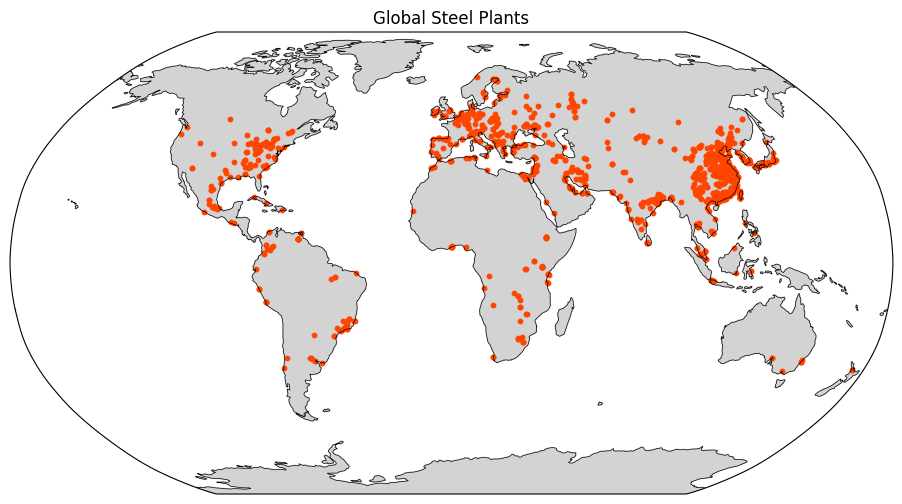

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load your shapefile
gdf = gpd.read_file(output_path + "combined_steel_plants.shp")
gdf = gdf.to_crs(epsg=4326)  # Ensure data is in latitude and longitude

# Define the Robinson projection
projection = ccrs.Robinson()

# Create a subplot with the Robinson projection
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(12, 6))

# Plotting the points
# Converting GeoDataFrame to use the `.plot` method from matplotlib for GeoDataFrames
gdf.plot(ax=ax, transform=ccrs.Geodetic(), marker='o', color='orangered', markersize=10)

# Adding geographical features
ax.coastlines(resolution='110m', color='black', linewidth=0.5)
ax.add_feature(cfeature.LAND, color='lightgray',linewidth=1)
ax.set_global()  # Optionally set a global extent

# Set the title
ax.set_title('Global Steel Plants')

plt.savefig(plot_path + "steel_plants.pdf", dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

In [41]:
ds = xr.open_dataset(output_path + "T.steel_plants.2000-2022.a.nc")
ds["steel_cap"] = (ds["steel_plants_capacity"] * 1e9) / ds["grid_area"]
ds

<xarray.Dataset> Size: 48MB
Dimensions:                (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                    (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                   (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    steel_plants_capacity  (time, lat, lon) float64 12MB nan nan nan ... nan nan
    grid_area              (time, lat, lon) float64 12MB ...
    land_frac              (time, lat, lon) float64 12MB ...
    steel_cap              (time, lat, lon) float64 12MB nan nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [42]:
mean_capacity = ds["steel_plants_capacity"].mean("time").to_dataset(name="mean_capacity")
mean_capacity

<xarray.Dataset> Size: 523kB
Dimensions:        (lon: 360, lat: 180)
Coordinates:
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat            (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    mean_capacity  (lat, lon) float64 518kB nan nan nan nan ... nan nan nan nan

In [43]:
mean_cap= ds["steel_cap"].mean("time").to_dataset(name="mean_cap")
mean_cap

<xarray.Dataset> Size: 523kB
Dimensions:   (lon: 360, lat: 180)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    mean_cap  (lat, lon) float64 518kB nan nan nan nan nan ... nan nan nan nan

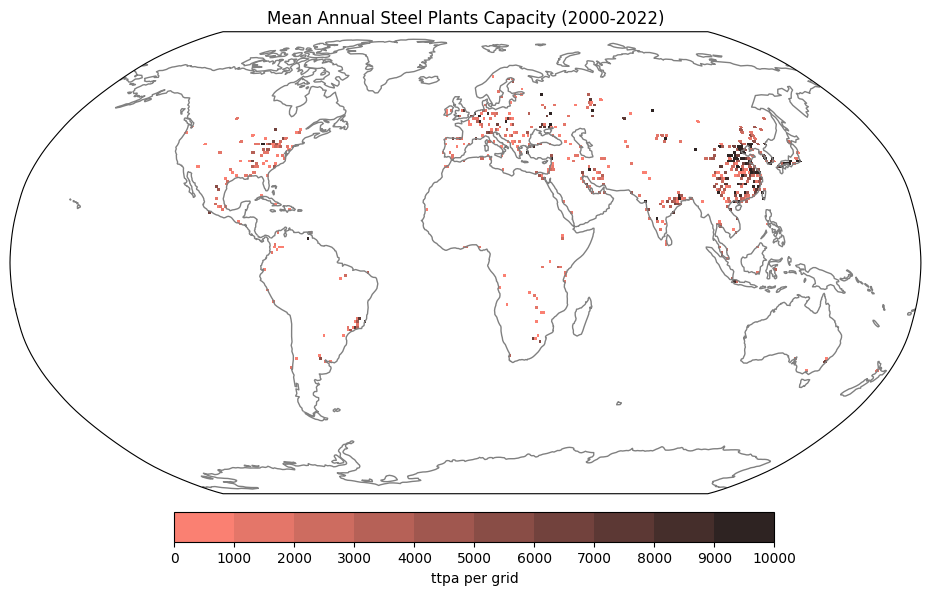

<GeoAxes: title={'center': 'Mean Annual Steel Plants Capacity (2000-2022)'}>

In [44]:
import seaborn as sns

ssm.plot_map(mean_capacity, "mean_capacity", color=sns.color_palette("dark:salmon_r", as_cmap=True), title="Mean Annual Steel Plants Capacity (2000-2022)", label="ttpa per grid", levels=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
            output_dir=plot_path, filename="mean_steel_capacity")

# Dasymmetric Mapping

In [45]:
df_steel = pd.read_csv(output_path + "crude_steel_merged.csv")
df_steel['year'] = pd.to_datetime(df_steel['year'], errors='coerce')
df_steel = df_steel[(df_steel['year'].dt.year >= 2000) & (df_steel['year'].dt.year <= 2022)]
df_steel['steel_com'] = df_steel['steel_com'] * 1e6
df_steel['year'] = df_steel['year'].dt.year
unique_years = df_steel["year"].unique()
unique_years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022], dtype=int32)

In [46]:
df_steel["steel_com"].sum()

np.float64(3.3242766564833332e+16)

In [47]:
# Filter rows where ISO3 is "SCG" and steel_com is not NaN
scg_rows = df_steel[(df_steel['ISO3'] == 'SCG') & df_steel['steel_com'].notna()]

# Create an empty list to store new rows
new_rows = []

# Iterate over each row
for index, row in scg_rows.iterrows():
    # Split steel_com into half
    steel_com_half = row['steel_com'] / 2
    
    # Create two new rows, one for SRB and one for MNE
    row_srb = row.copy()
    row_srb['ISO3'] = 'SRB'
    row_srb['steel_com'] = steel_com_half
    new_rows.append(row_srb)
    
    row_mne = row.copy()
    row_mne['ISO3'] = 'MNE'
    row_mne['steel_com'] = steel_com_half
    new_rows.append(row_mne)

# Convert the list of new rows into a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows to the original dataframe
df_steel_updated = pd.concat([df_steel, new_rows_df], ignore_index=True)

# Drop all rows where ISO3 is "SCG"
df_steel_updated = df_steel_updated[df_steel_updated['ISO3'] != 'SCG']

# Reset index
df_steel_updated.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
df_steel_updated

,Unnamed: 0,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source
0,2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
1,3,AFG,NaN,2001,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
2,4,AFG,NaN,2002,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
3,5,AFG,NaN,2003,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
4,6,AFG,NaN,2004,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,3608,MNE,Serbia and Montenegro,2004,1175000.0,BGS,Serbia and Montenegro,1196809.0,usgs,Serbia and Montenegro,1175000.0,wst,5.875000e+11,"BGS, WST"
2499,3609,SRB,Serbia and Montenegro,2005,1292000.0,BGS,Serbia and Montenegro,1314115.0,usgs,Serbia and Montenegro,1292000.0,wst,6.460000e+11,"BGS, WST"
2500,3609,MNE,Serbia and Montenegro,2005,1292000.0,BGS,Serbia and Montenegro,1314115.0,usgs,Serbia and Montenegro,1292000.0,wst,6.460000e+11,"BGS, WST"
2501,3610,SRB,NaN,2006,NaN,NaN,Serbia and Montenegro,NaN,usgs,Serbia and Montenegro,1823000.0,wst,9.115000e+11,WST


In [48]:
df_steel_updated["steel_com"].sum()

np.float64(3.3242766564833336e+16)

In [50]:
ds_plant = xr.open_dataset(output_path + "T.steel_plants.2000-2022.a.nc")

source = (
    "British Geological Survey. (1970-2022). World Mineral Statistics Dataset.\n"
    "USGS Iron Ore Statistics and Information (1998-2021).\n"
    "World Steel Association (1998-2021)."
)

dataset_list = []
for time in unique_years:
    print(time)
    df_filtered = df_steel_updated[df_steel_updated["year"] == time].reset_index()
    time_str = f"{time}-01-01"
    ds = ssm.table_2_grid(surrogate_variable="steel_plants_capacity", tabular_column="steel_com", surrogate_data=ds_plant,
                    tabular_data=df_filtered, variable_name="crude_steel", long_name="Crude Steel Production", units="g m-2 y-1", source=source,
                    time=time_str, normalize_by_area=True, verbose=True)
    dataset_list.append(ds)

merged_ds = xr.merge(dataset_list)
merged_ds

2000
Distributing crude_steel onto steel_plants_capacity.
Global sum of jurisdictional dataset : 849145127833333.4
Global stats after gridding: 849145127833333.25
2001
Distributing crude_steel onto steel_plants_capacity.
Global sum of jurisdictional dataset : 851067372333333.4
Global stats after gridding: 851067372333333.25
2002
Distributing crude_steel onto steel_plants_capacity.
Global sum of jurisdictional dataset : 904076041666666.6
Global stats after gridding: 904076041666666.62
2003
Distributing crude_steel onto steel_plants_capacity.
Global sum of jurisdictional dataset : 974374039000000.0
Global stats after gridding: 974374039000000.00
2004
Distributing crude_steel onto steel_plants_capacity.
Global sum of jurisdictional dataset : 1073684091833333.2
Global stats after gridding: 1073684091833333.38
2005
Distributing crude_steel onto steel_plants_capacity.
Global sum of jurisdictional dataset : 1145404914333333.2
Global stats after gridding: 1145404914333333.25
2006
Distributing 

<xarray.Dataset> Size: 13MB
Dimensions:      (lat: 180, lon: 360, time: 23)
Coordinates:
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon          (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time         (time) datetime64[ns] 184B 2000-01-01 2001-01-01 ... 2022-01-01
Data variables:
    crude_steel  (time, lat, lon) float64 12MB nan nan nan nan ... nan nan nan
    grid_area    (lat, lon) float64 518kB 1.089e+08 1.089e+08 ... 1.089e+08
    land_frac    (lat, lon) float64 518kB 0.005732 0.005732 0.005732 ... 0.0 0.0
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [51]:
ds_plant = ds_plant.drop_vars("land_frac")
ds_com = xr.merge([merged_ds, ds_plant])
ds_com

<xarray.Dataset> Size: 36MB
Dimensions:                (lat: 180, lon: 360, time: 23)
Coordinates:
  * lat                    (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * time                   (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    crude_steel            (time, lat, lon) float64 12MB nan nan nan ... nan nan
    grid_area              (lat, lon, time) float64 12MB 1.089e+08 ... 1.089e+08
    land_frac              (lat, lon) float64 518kB 0.005732 0.005732 ... 0.0
    steel_plants_capacity  (time, lat, lon) float64 12MB ...
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [52]:
# Sort variables except for the ones that should be at the end
ds = ds_com
sorted_variables = sorted([var for var in ds.data_vars if var not in ["land_frac", "land_area", "grid_area"]])

# Add the specified variables at the end in the desired order
for var in ["land_frac", "land_area", "grid_area"]:
    if var in ds.data_vars:
        sorted_variables.append(var)

# Create a new dataset with sorted variables and the specified variables at the end
ds_sorted = ds[sorted_variables]
ds_sorted

<xarray.Dataset> Size: 36MB
Dimensions:                (time: 23, lat: 180, lon: 360)
Coordinates:
  * lat                    (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                    (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * time                   (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    crude_steel            (time, lat, lon) float64 12MB nan nan nan ... nan nan
    steel_plants_capacity  (time, lat, lon) float64 12MB ...
    land_frac              (lat, lon) float64 518kB 0.005732 0.005732 ... 0.0
    grid_area              (lat, lon, time) float64 12MB 1.089e+08 ... 1.089e+08
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [53]:
ds_sorted.to_netcdf(output_path + "T.steel.2000-2022.a.nc")

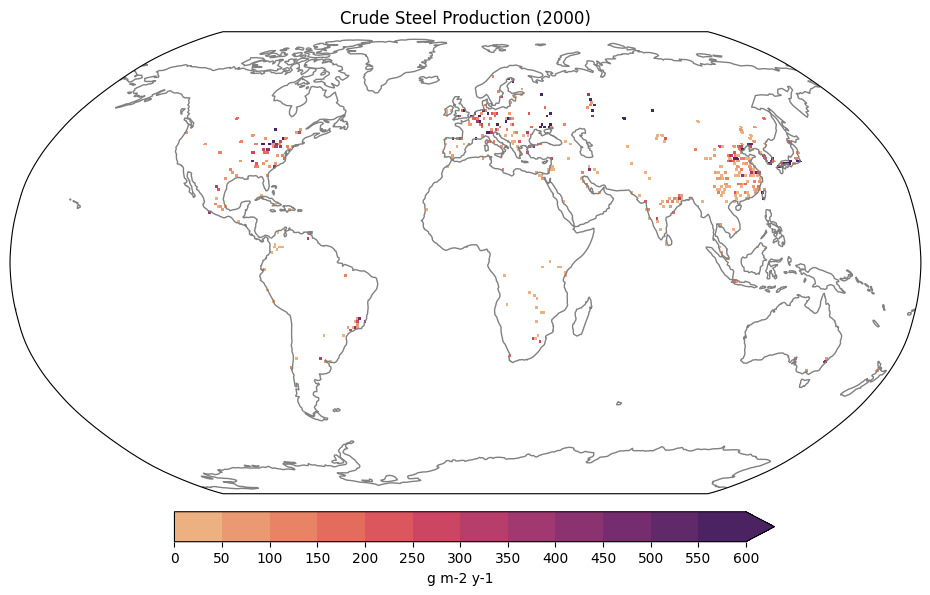

<GeoAxes: title={'center': 'Crude Steel Production (2000)'}>

In [54]:
ds = xr.open_dataset(output_path + "T.steel.2000-2022.a.nc")
dd = ds.sel(time="2000-01-01")
ssm.plot_map(dd, "crude_steel", color="flare", levels=12, vmin=0, vmax=600, extend_max=True, label="g m-2 y-1", title="Crude Steel Production (2000)")

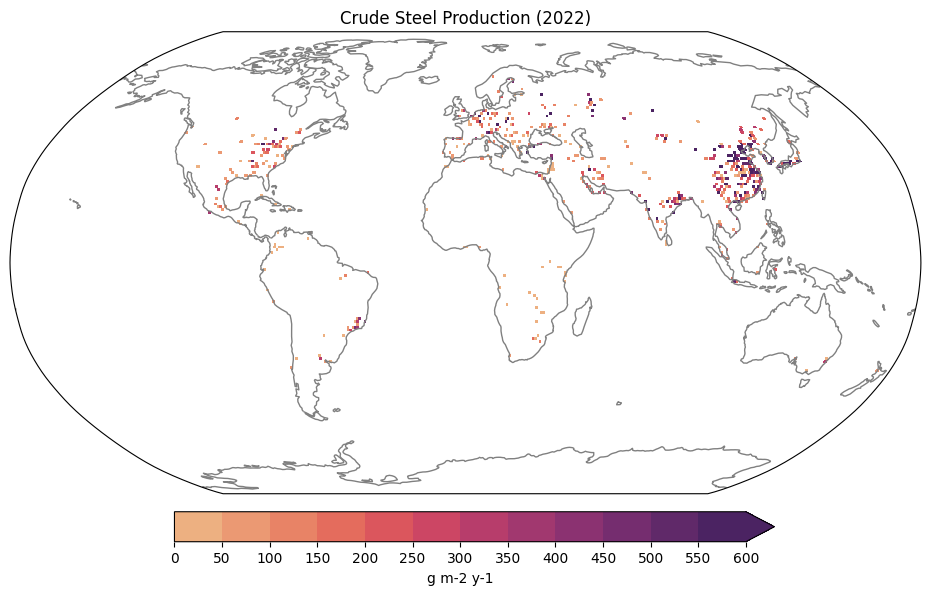

<GeoAxes: title={'center': 'Crude Steel Production (2022)'}>

In [55]:
ds = xr.open_dataset(output_path + "T.steel.2000-2022.a.nc")
dd = ds.sel(time="2022-01-01")
ssm.plot_map(dd, "crude_steel", color="flare", levels=12, vmin=0, vmax=600, extend_max=True, label="g m-2 y-1", title="Crude Steel Production (2022)")

# Crude Steel from Scarps

- Scrap data were collected from the Bureau of International Recycling (BIR): https://www.bir.org/en/publications/facts-figures.
- The datasets are compiled and summarized in Steel_Scraps_Share_Crude_Steel_BIR.xlsx.

In [56]:
# Define the data
data = {
    "year": [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 
             2016, 2017, 2018, 2019, 2020, 2021, 2022],
    "China": [None, 16.0, 14.0, 14.4, 14.5, 13.8, 13, 11.5, 10.4, 10.6, 10.4, 
              11.2, 17, 20.2, 21.7, 21.8, 21.9, 22.2],
    "EU-27/28": [54.0, 55.7, 55.5, 56.2, 58.0, 55.5, 56.3, 55.9, 54.3, 54.1, 
                 54.8, 53.2, 55.5, 54.4, 55.0, 57.0, 57.8, 58.2],
    "USA": [69.5, 64.9, 65.2, 72.2, None, 63.4, 72.9, 71.0, 67.9, 70.3, 71.7, 
            72.2, 72.1, 69.4, 69.1, 69.1, 69.2, 70.3],
    "Japan": [None, 36.3, 36.9, 37.7, 34.1, 35.0, 34.6, 33.1, 33.2, 33.3, 31.9, 
              32.1, 34.2, 35.0, 33.9, 34.8, 34.8, 36.8],
    "Turkey": [83.8, 86.7, 87.6, 85.4, 85.0, 86.9, 90.3, 90.3, 87.6, 82.9, 82.7, 
               78.0, 80.8, 83.9, 82.8, 84.1, 86.1, 86.3],
    "Russia": [None, 28.53, 29.56, 29.34, 22.83, 30.79, 30.5, 28.6, 28.1, 27.0, 
               24.4, 39.5, 39.5, 41.0, 43.7, 40.9, 41.7, 41.1],
    "Korea, Republic of": [None, None, None, None, None, None, 45.0, 47.2, 49.5, 45.6, 
                   42.9, 39.9, 43.2, 41.4, 39.9, 38.5, 40.2, 39.9]
}

# Create a DataFrame
df_sp = pd.DataFrame(data)
# Display the DataFrame
# Reshape the DataFrame to have columns: Country, Year, "% Scrap"
df_sp = df_sp.melt(id_vars=["year"], var_name="Country", value_name="% Scrap")
# Ensure the Year column is of type int for consistency
df_sp["year"] = df_sp["year"].astype(int)
df_sp


,year,Country,% Scrap
0,2005,China,NaN
1,2006,China,16.0
2,2007,China,14.0
3,2008,China,14.4
4,2009,China,14.5
...,...,...,...
121,2018,"Korea, Republic of",41.4
122,2019,"Korea, Republic of",39.9
123,2020,"Korea, Republic of",38.5
124,2021,"Korea, Republic of",40.2


In [57]:
import pandas as pd

# Creating the DataFrame from the provided data
data = {
    "Country": [
        "Austria", "Belgium", "Bulgaria", "Czech Republic", "Finland", "France", "Germany", "Greece", 
        "Hungary", "Italy", "Latvia", "Luxembourg", "Netherlands", "Poland", "Portugal", "Romania", 
        "Slovakia", "Slovenia", "Spain", "Sweden", "United Kingdom", "Croatia", "EU-27/28"
    ],
    2010: [31.46, 39.65, 108.98, 40.98, 41.81, 55.56, 44.70, 116.29, 30.13, 78.42, 45.86, 112.02, 
           25.44, 68.03, 129.91, 60.84, 33.60, 113.27, 84.62, 48.26, 38.22, None, 56.86],
    2011: [33.11, 44.65, 111.38, 41.12, 41.40, 52.62, 42.92, 117.02, 26.82, 79.08, 71.91, 112.01, 
           26.60, 68.06, 112.51, 58.56, 32.08, 110.23, 85.88, 45.56, 41.04, None, 55.88],
    2012: [34.32, 42.88, 109.00, 39.55, 45.78, 53.10, 44.89, 116.92, 24.97, 76.03, 112.55, 112.05, 
           24.35, 67.23, 112.45, 60.39, 30.52, 116.14, 84.18, 46.97, 38.35, None, 55.89],
    2013: [33.41, 37.29, 108.99, 37.07, 48.02, 48.87, 44.19, 114.12, 36.13, 82.17, 123.74, 112.77, 
           25.22, 63.32, 109.12, 51.69, 32.01, 116.83, 81.56, 46.23, 34.10, 107.19, 54.23],
    2014: [35.50, 39.30, 107.19, 36.08, 51.85, 46.89, 44.51, 117.32, 41.49, 82.91, None, 112.63, 
           25.14, 59.48, 106.18, 60.01, 29.97, 111.54, 80.33, 46.51, 33.52, 106.56, 54.08],
    2015: [35.02, 42.22, 107.18, 35.84, 53.39, 49.23, 43.33, 117.69, 37.43, 89.30, None, 112.65, 
           24.75, 60.94, 106.04, 54.65, 29.48, 110.93, 79.48, 48.35, 34.03, None, 54.82],
    2016: [34.74, 40.00, 107.21, 35.44, 54.40, 48.76, 43.63, 117.36, 43.96, 85.23, None, 112.64, 
           22.89, 61.89, 106.47, 53.85, 28.68, 112.56, 77.08, 47.33, 33.48, None, 54.54],
    2017: [32.32, 41.12, 107.21, 36.37, 54.23, 46.39, 43.94, 117.37, 42.03, 89.70, None, 112.62, 
           20.23, 63.27, 106.07, 59.60, 29.61, 111.27, 76.59, 49.16, 35.98, None, 55.52]
}

df_eu = pd.DataFrame(data)
df_eu.set_index("Country", inplace=True)

# Replace values > 100 with the EU-27/28 average for that year
for year in df_eu.columns:
    avg_value = df_eu.loc["EU-27/28", year]  # Get the EU-27/28 average for that year
    df_eu.loc[df_eu[year] > 100, year] = avg_value  # Replace values greater than 100 with the average


# Reshape the EU27/28 DataFrame (df) to have columns: Country, Year, "% Scrap"
df_eu = df_eu.reset_index().melt(id_vars=["Country"], var_name="year", value_name="% Scrap")
# Ensure the Year column is of type int for consistency
df_eu["year"] = df_eu["year"].astype(int)
df_eu

,Country,year,% Scrap
0,Austria,2010,31.46
1,Belgium,2010,39.65
2,Bulgaria,2010,56.86
3,Czech Republic,2010,40.98
4,Finland,2010,41.81
...,...,...,...
179,Spain,2017,76.59
180,Sweden,2017,49.16
181,United Kingdom,2017,35.98
182,Croatia,2017,NaN


In [58]:
# Function to fill missing values
def fill_missing_values(df):
    # Step 1: Fill missing values with the average of the available years for that country
    df['% Scrap'] = df.groupby('Country')['% Scrap'].transform(
        lambda x: x.fillna(x.mean())
    )
    
    # Step 2: Fill remaining missing values using the corresponding EU-27/28 data
    eu_data = df[df['Country'] == 'EU-27/28'][['year', '% Scrap']].set_index('year')['% Scrap']
    
    def fill_with_eu(row):
        if pd.isna(row['% Scrap']):  # If the % Scrap is still NaN
            return eu_data.get(row['year'], row['% Scrap'])
        return row['% Scrap']
    
    df['% Scrap'] = df.apply(fill_with_eu, axis=1)
    
    return df

# Assuming your DataFrame is named df_long
df_eu = fill_missing_values(df_eu)
df_eu

,Country,year,% Scrap
0,Austria,2010,31.460
1,Belgium,2010,39.650
2,Bulgaria,2010,56.860
3,Czech Republic,2010,40.980
4,Finland,2010,41.810
...,...,...,...
179,Spain,2017,76.590
180,Sweden,2017,49.160
181,United Kingdom,2017,35.980
182,Croatia,2017,54.155


In [59]:
df_eu[df_eu["Country"] == "United Kingdom"]

,Country,year,% Scrap
20,United Kingdom,2010,38.22
43,United Kingdom,2011,41.04
66,United Kingdom,2012,38.35
89,United Kingdom,2013,34.10
112,United Kingdom,2014,33.52
135,United Kingdom,2015,34.03
158,United Kingdom,2016,33.48
181,United Kingdom,2017,35.98


In [61]:
df_merged = df_sp.merge(df_eu, how='outer')
# Drop duplicate rows for each country (keeping the first occurrence)
df_merged = df_merged[df_merged["Country"] != "EU-27/28"]
df_merged = ssm.add_iso3_column(df_merged, "Country")
df_merged

,year,Country,% Scrap,ISO3
0,2005,China,NaN,CHN
2,2005,Japan,NaN,JPN
3,2005,"Korea, Republic of",NaN,KOR
4,2005,Russia,NaN,RUS
5,2005,Turkey,83.8,TUR
...,...,...,...,...
305,2022,Japan,36.8,JPN
306,2022,"Korea, Republic of",39.9,KOR
307,2022,Russia,41.1,RUS
308,2022,Turkey,86.3,TUR


In [62]:
df_steel = pd.read_csv(output_path + "crude_steel_merged.csv")
df_steel['year'] = pd.to_datetime(df_steel['year'], errors='coerce')
df_steel = df_steel[(df_steel['year'].dt.year >= 2000) & (df_steel['year'].dt.year <= 2022)]
df_steel['year'] = df_steel['year'].dt.year
df_steel

,Unnamed: 0,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source
2,2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
3,3,AFG,NaN,2001,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
4,4,AFG,NaN,2002,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
5,5,AFG,NaN,2003,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
6,6,AFG,NaN,2004,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4634,4634,ZWE,Zimbabwe,2018,1322.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,1322.0,BGS
4635,4635,ZWE,Zimbabwe,2019,3583.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3583.0,BGS
4636,4636,ZWE,Zimbabwe,2020,5196.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,5196.0,BGS
4637,4637,ZWE,Zimbabwe,2021,3921.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3921.0,BGS


In [63]:
df_crude = df_steel.merge(df_merged[["year", "ISO3", "% Scrap"]], on=["ISO3", "year"], how='outer')
df_crude

,Unnamed: 0,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source,% Scrap
0,2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN
1,3,AFG,NaN,2001,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN
2,4,AFG,NaN,2002,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN
3,5,AFG,NaN,2003,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN
4,6,AFG,NaN,2004,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,4634,ZWE,Zimbabwe,2018,1322.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,1322.0,BGS,NaN
2508,4635,ZWE,Zimbabwe,2019,3583.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3583.0,BGS,NaN
2509,4636,ZWE,Zimbabwe,2020,5196.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,5196.0,BGS,NaN
2510,4637,ZWE,Zimbabwe,2021,3921.0,BGS,Zimbabwe,NaN,usgs,Zimbabwe,NaN,wst,3921.0,BGS,NaN


Global % of scrap used for steel production was collected from here: https://doi.org/10.1016/j.resconrec.2013.10.002

In [65]:
# Load the scrap percentage data
scrap_data = {
    "year": list(range(2000, 2021)),
    "% scrap global": [43.82, 44.65, 44.36, 42.58, 42.86, 41.70, 41.06, 39.75, 40.63, 
                36.36, 38.11, 38.49, 37.80, 38.03, 38.27, 38.55, 38.83, 39.18, 
                39.44, 39.88, 40.25]
}
scrap_df = pd.DataFrame(scrap_data)

# Define the moving average window size
window_size = 3

# Predict for the years 2021 and 2022
for year in range(2021, 2023):
    # Calculate the moving average of the last few years
    moving_avg = scrap_df["% scrap global"][-window_size:].mean()
    # Create a new row as a DataFrame
    new_row = pd.DataFrame({"year": [year], "% scrap global": [moving_avg]})
    # Append the new row to the existing DataFrame using pd.concat
    scrap_df = pd.concat([scrap_df, new_row], ignore_index=True)

scrap_df    

,year,% scrap global
0,2000,43.820000
1,2001,44.650000
2,2002,44.360000
3,2003,42.580000
4,2004,42.860000
5,2005,41.700000
6,2006,41.060000
7,2007,39.750000
8,2008,40.630000
9,2009,36.360000


In [66]:
df_crude = df_crude.merge(scrap_df, on=["year"], how='outer')
df_crude

,Unnamed: 0,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source,% Scrap,% scrap global
0,2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN,43.820000
1,39,AGO,NaN,2000,NaN,NaN,Angola,NaN,usgs,Angola,9000.0,wst,9000.0,WST,NaN,43.820000
2,67,ALB,Albania,2000,64700.0,BGS,Albania,64700.0,usgs,Albania,5000.0,wst,64700.0,"BGS, USGS",NaN,43.820000
3,97,ARE,United Arab Emirates,2000,90000.0,BGS,United Arab Emirates,NaN,usgs,United Arab Emirates,90000.0,wst,90000.0,"BGS, WST",NaN,43.820000
4,150,ARG,Argentina,2000,4479204.0,BGS,Argentina,4472000.0,usgs,Argentina,4474000.0,wst,4473000.0,"WST, USGS",NaN,43.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,4437,VEN,Venezuela,2022,27100.0,BGS,Venezuela,27000.0,usgs,NaN,NaN,NaN,27050.0,"BGS, USGS",NaN,39.995556
2508,4481,VNM,Vietnam,2022,20003600.0,BGS,Viet Nam,20004000.0,usgs,NaN,NaN,NaN,20003800.0,"BGS, USGS",NaN,39.995556
2509,4560,ZAF,South Africa,2022,4402500.0,BGS,South Africa,4403000.0,usgs,NaN,NaN,NaN,4402750.0,"BGS, USGS",NaN,39.995556
2510,4585,ZMB,NaN,2022,NaN,NaN,Zambia,200000.0,usgs,NaN,NaN,NaN,200000.0,USGS,NaN,39.995556


In [67]:
# Function to fill missing % Scrap values
def fill_missing_scrap(df):
    # Step 1: Fill missing % Scrap values for a country based on the country's average
    df['% Scrap'] = df.groupby('ISO3')['% Scrap'].transform(
        lambda x: x.fillna(x.mean()) if not x.mean() != x.mean() else x
    )
    
    # Step 2: Fill remaining missing % Scrap using % scrap global for that year
    df['% Scrap'] = df.apply(
        lambda row: row['% scrap global'] if pd.isna(row['% Scrap']) and not pd.isna(row['% scrap global']) else row['% Scrap'], axis=1
    )
    
    # Step 3: Leave rows with missing steel_com unchanged
    df.loc[df['steel_com'].isna(), '% Scrap'] = None
    
    return df

# Apply the function to the DataFrame
df_filled = fill_missing_scrap(df_crude)
df_filled

,Unnamed: 0,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source,% Scrap,% scrap global
0,2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN,43.820000
1,39,AGO,NaN,2000,NaN,NaN,Angola,NaN,usgs,Angola,9000.0,wst,9000.0,WST,43.820000,43.820000
2,67,ALB,Albania,2000,64700.0,BGS,Albania,64700.0,usgs,Albania,5000.0,wst,64700.0,"BGS, USGS",43.820000,43.820000
3,97,ARE,United Arab Emirates,2000,90000.0,BGS,United Arab Emirates,NaN,usgs,United Arab Emirates,90000.0,wst,90000.0,"BGS, WST",43.820000,43.820000
4,150,ARG,Argentina,2000,4479204.0,BGS,Argentina,4472000.0,usgs,Argentina,4474000.0,wst,4473000.0,"WST, USGS",43.820000,43.820000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,4437,VEN,Venezuela,2022,27100.0,BGS,Venezuela,27000.0,usgs,NaN,NaN,NaN,27050.0,"BGS, USGS",39.995556,39.995556
2508,4481,VNM,Vietnam,2022,20003600.0,BGS,Viet Nam,20004000.0,usgs,NaN,NaN,NaN,20003800.0,"BGS, USGS",39.995556,39.995556
2509,4560,ZAF,South Africa,2022,4402500.0,BGS,South Africa,4403000.0,usgs,NaN,NaN,NaN,4402750.0,"BGS, USGS",39.995556,39.995556
2510,4585,ZMB,NaN,2022,NaN,NaN,Zambia,200000.0,usgs,NaN,NaN,NaN,200000.0,USGS,39.995556,39.995556


In [71]:
df_filled.to_csv(output_path + "crude_steel_merged_scrap_added.csv", index=False)

# Gridding by plant types

In [74]:
gdf = gpd.read_file(raw_path + "combined_steel_plants.shp")
gdf

,Plant ID,Plant name,Plant na_1,Other plan,Other pl_1,Owner,Owner (oth,Owner GEM,Owner Perm,SOE Status,...,ISO 14001,ISO 50001,Responsibl,Main produ,Main pro_1,Detailed p,Power sour,Iron ore s,Met coal s,geometry
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",None,ABA Çelik Demir AŞ,None,E100000131190,NaN,None,...,None,None,None,electric,EAF,1 EAF (110-tonne),None,None,None,POINT (36.21733 36.74741)
1,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,None,Abinski Elektrometallurgicheski Zavod OOO,None,E100000130999,5.039667e+09,None,...,2022,None,None,electric,EAF,1 EAF (130-tonne),None,None,None,POINT (38.12751 44.88194)
2,P100000120020,Abul Khair Steel Sitakunda plant,None,AKS Sitakund; AKS Long Steel; AKS Melting,None,Abul Khair Steel Ltd,None,E100000131068,5.074007e+09,None,...,None,None,None,electric,EAF,1 EAF,None,None,None,POINT (91.73483 22.47201)
3,P100000120620,Acciaierie d'Italia Taranto steel plant,None,ILVA Taranto steel plant (predecessor); ILVA S...,None,Acciaierie d'italia SpA,None,E100001010116,5.067495e+09,Partial,...,2022,2022,None,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,None,None,None,POINT (17.20759 40.50899)
4,P100000120620,Acciaierie d'Italia Taranto steel plant,None,ILVA Taranto steel plant (predecessor); ILVA S...,None,Acciaierie d'italia SpA,None,E100001010116,5.067495e+09,Partial,...,2022,2022,None,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,None,None,None,POINT (17.20759 40.50899)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,None,None,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,None,None,POINT (-57.51219 -25.09026)
1431,None,None,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,None,None,POINT (-56.10027 -34.81024)
1432,None,Myingyan No. 1 Steel Mill,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,None,None,POINT (95.37486 21.37642)
1433,None,Master Steel Ltd,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,None,None,POINT (30.09919 -1.97849)


In [75]:
def get_scrap_usage(equipment):
    if equipment is None or not isinstance(equipment, str):
        return 1.35  # Default value for unspecified equipment

    equipment = equipment.upper()

    # Check specific combined cases first
    if 'EAF' in equipment and 'DRI' in equipment:
        return 1.75
    elif 'EAF' in equipment and 'BOF' in equipment:
        return 1.30
    elif 'EAF' in equipment:
        return 1.90
    elif 'BOF' in equipment and 'DRI' in equipment:
        return 1.35
    elif 'BOF' in equipment:
        return 1.25
    elif 'OHF' in equipment:
        return 1.40
    elif 'BF' in equipment:
        return 1.05
    elif 'DRI' in equipment:
        return 1.05
    else:
        return 1.35  # Default

    
# Applying the function
gdf['scrap_weight'] = gdf['Main pro_1'].apply(get_scrap_usage)
gdf['capacity_scrap'] = gdf['Nominal cr'] * gdf['scrap_weight']
gdf[['Nominal cr', 'capacity_scrap', 'scrap_weight']]
gdf

,Plant ID,Plant name,Plant na_1,Other plan,Other pl_1,Owner,Owner (oth,Owner GEM,Owner Perm,SOE Status,...,Responsibl,Main produ,Main pro_1,Detailed p,Power sour,Iron ore s,Met coal s,geometry,scrap_weight,capacity_scrap
0,P100000120882,Aba Iron and Steel Payas plant,ABA DEMİR ÇELİK (Turkish),"EEY Iron and Steel, Nursan Steek Payas Plant (...",None,ABA Çelik Demir AŞ,None,E100000131190,NaN,None,...,None,electric,EAF,1 EAF (110-tonne),None,None,None,POINT (36.21733 36.74741),1.90,2090.0
1,P100000120802,Abinsk Electric Steel Works,Абинский ЭлектроМеталлургический завод (Russian),AEMZ; AESW; AEMK; ASW,None,Abinski Elektrometallurgicheski Zavod OOO,None,E100000130999,5.039667e+09,None,...,None,electric,EAF,1 EAF (130-tonne),None,None,None,POINT (38.12751 44.88194),1.90,3040.0
2,P100000120020,Abul Khair Steel Sitakunda plant,None,AKS Sitakund; AKS Long Steel; AKS Melting,None,Abul Khair Steel Ltd,None,E100000131068,5.074007e+09,None,...,None,electric,EAF,1 EAF,None,None,None,POINT (91.73483 22.47201),1.90,2660.0
3,P100000120620,Acciaierie d'Italia Taranto steel plant,None,ILVA Taranto steel plant (predecessor); ILVA S...,None,Acciaierie d'italia SpA,None,E100001010116,5.067495e+09,Partial,...,None,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,None,None,None,POINT (17.20759 40.50899),1.25,9750.0
4,P100000120620,Acciaierie d'Italia Taranto steel plant,None,ILVA Taranto steel plant (predecessor); ILVA S...,None,Acciaierie d'italia SpA,None,E100001010116,5.067495e+09,Partial,...,None,integrated (BF),"BF, BOF",coking plant; sinter plant; 4 BOF,None,None,None,POINT (17.20759 40.50899),1.25,1790.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,None,None,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,POINT (-57.51219 -25.09026),1.35,675.0
1431,None,None,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,POINT (-56.10027 -34.81024),1.35,675.0
1432,None,Myingyan No. 1 Steel Mill,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,POINT (95.37486 21.37642),1.35,675.0
1433,None,Master Steel Ltd,None,None,None,None,None,None,NaN,None,...,None,None,None,None,None,None,None,POINT (30.09919 -1.97849),1.35,675.0


In [76]:
years = list(range(2000, 2023, 1))

source = (
    "Worldwide: Global Energy Monitor, Global Steel Plant Tracker, April 2024 (V1) release.\n"
    "Missing Countries: Manual Google Search from multiple sources."
)
dataset_list = []

for year in years:
    # Filter df_dates where the year is between 'Start date' and 'Retired Date'
    filtered_gdf = gdf[
    (gdf['Start date'] <= year) & 
    (gdf['Retired Da'] >= year)
        ].copy()  # Make an explicit copy
    
    time_str = f"{year}-01-01"
    ds_st = ssm.point_2_grid(point_data=filtered_gdf, variable_name="scrap_capacity", long_name="Steel Plants Scrap Capacity",
                     units="ttpa per grid", source=source, time=time_str, agg_column='capacity_scrap', 
                     agg_function="sum", verbose="yes")
    dataset_list.append(ds_st)

merged_ds = xr.merge(dataset_list)
merged_ds

Global stats before gridding : 2781576.83
Global stats after gridding: 2781576.83
Global stats before gridding : 2862765.47
Global stats after gridding: 2862765.47
Global stats before gridding : 3054708.08
Global stats after gridding: 3054708.08
Global stats before gridding : 3244040.62
Global stats after gridding: 3244040.62
Global stats before gridding : 3287215.42
Global stats after gridding: 3287215.42
Global stats before gridding : 3338062.68
Global stats after gridding: 3338062.68
Global stats before gridding : 3411123.19
Global stats after gridding: 3411123.19
Global stats before gridding : 3474839.48
Global stats after gridding: 3474839.48
Global stats before gridding : 3537223.89
Global stats after gridding: 3537223.89
Global stats before gridding : 3616356.96
Global stats after gridding: 3616356.96
Global stats before gridding : 3669505.96
Global stats after gridding: 3669505.96
Global stats before gridding : 3738771.79
Global stats after gridding: 3738771.79
Global stats bef

<xarray.Dataset> Size: 36MB
Dimensions:         (lat: 180, lon: 360, time: 23)
Coordinates:
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    scrap_capacity  (time, lat, lon) float64 12MB nan nan nan ... nan nan nan
    grid_area       (time, lat, lon) float64 12MB 1.089e+08 ... 1.089e+08
    land_frac       (time, lat, lon) float64 12MB 0.005732 0.005732 ... 0.0 0.0
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [77]:
df_steel = pd.read_csv(output_path + "crude_steel_merged_scrap_added.csv")
df_steel['steel_com'] = df_steel['steel_com'] * 1e6
df_steel['steel_from_scrap'] = df_steel['steel_from_scrap'] * 1e6
df_steel['steel_from_ore'] = df_steel['steel_from_ore'] * 1e6
unique_years = df_steel["year"].unique()
unique_years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022])

In [78]:
print(df_steel["steel_com"].sum())
print(df_steel["steel_from_scrap"].sum())
print(df_steel["steel_from_ore"].sum())

3.3242766564833332e+16
1.1049611190538944e+16
2.2193155374294388e+16


In [79]:
# Filter rows where ISO3 is "SCG" and steel_com is not NaN
scg_rows = df_steel[(df_steel['ISO3'] == 'SCG') & df_steel['steel_com'].notna()]

# Create an empty list to store new rows
new_rows = []

# Iterate over each row
for index, row in scg_rows.iterrows():
    # Split steel_com, steel_from_scrap, and steel_from_ore into half
    steel_com_half = row['steel_com'] / 2
    steel_from_scrap_half = row['steel_from_scrap'] / 2
    steel_from_ore_half = row['steel_from_ore'] / 2
    
    # Create two new rows, one for SRB and one for MNE
    row_srb = row.copy()
    row_srb['ISO3'] = 'SRB'
    row_srb['steel_com'] = steel_com_half
    row_srb['steel_from_scrap'] = steel_from_scrap_half
    row_srb['steel_from_ore'] = steel_from_ore_half
    new_rows.append(row_srb)
    
    row_mne = row.copy()
    row_mne['ISO3'] = 'MNE'
    row_mne['steel_com'] = steel_com_half
    row_mne['steel_from_scrap'] = steel_from_scrap_half
    row_mne['steel_from_ore'] = steel_from_ore_half
    new_rows.append(row_mne)

# Convert the list of new rows into a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows to the original dataframe
df_steel_updated = pd.concat([df_steel, new_rows_df], ignore_index=True)

# Drop all rows where ISO3 is "SCG"
df_steel_updated = df_steel_updated[df_steel_updated['ISO3'] != 'SCG']

# Reset index
df_steel_updated.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
df_steel_updated

,Unnamed: 0,ISO3,country_trans,year,bgs_steel,source_bgs,Country_x,usgs_steel,source_usgs,Country_y,wst_steel,source_wst,steel_com,source,% Scrap,% scrap global,steel_from_scrap,steel_from_ore
0,2,AFG,NaN,2000,NaN,NaN,Afghanistan,NaN,usgs,NaN,NaN,NaN,NaN,NaN,NaN,43.82,NaN,NaN
1,39,AGO,NaN,2000,NaN,NaN,Angola,NaN,usgs,Angola,9000.0,wst,9.000000e+09,WST,43.82,43.82,3.943800e+09,5.056200e+09
2,67,ALB,Albania,2000,64700.0,BGS,Albania,64700.0,usgs,Albania,5000.0,wst,6.470000e+10,"BGS, USGS",43.82,43.82,2.835154e+10,3.634846e+10
3,97,ARE,United Arab Emirates,2000,90000.0,BGS,United Arab Emirates,NaN,usgs,United Arab Emirates,90000.0,wst,9.000000e+10,"BGS, WST",43.82,43.82,3.943800e+10,5.056200e+10
4,150,ARG,Argentina,2000,4479204.0,BGS,Argentina,4472000.0,usgs,Argentina,4474000.0,wst,4.473000e+12,"WST, USGS",43.82,43.82,1.960069e+12,2.512931e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,3608,MNE,Serbia and Montenegro,2004,1175000.0,BGS,Serbia and Montenegro,1196809.0,usgs,Serbia and Montenegro,1175000.0,wst,5.875000e+11,"BGS, WST",42.86,42.86,2.518025e+11,3.356975e+11
2499,3609,SRB,Serbia and Montenegro,2005,1292000.0,BGS,Serbia and Montenegro,1314115.0,usgs,Serbia and Montenegro,1292000.0,wst,6.460000e+11,"BGS, WST",41.70,41.70,2.693820e+11,3.766180e+11
2500,3609,MNE,Serbia and Montenegro,2005,1292000.0,BGS,Serbia and Montenegro,1314115.0,usgs,Serbia and Montenegro,1292000.0,wst,6.460000e+11,"BGS, WST",41.70,41.70,2.693820e+11,3.766180e+11
2501,3610,SRB,NaN,2006,NaN,NaN,Serbia and Montenegro,NaN,usgs,Serbia and Montenegro,1823000.0,wst,9.115000e+11,WST,41.06,41.06,3.742619e+11,5.372381e+11


In [80]:
print(df_steel["steel_com"].sum())
print(df_steel["steel_from_scrap"].sum())
print(df_steel["steel_from_ore"].sum())

3.3242766564833332e+16
1.1049611190538944e+16
2.2193155374294388e+16


In [83]:
source = (
    "Gross Crude Steel Production: Data sourced from BGS, USGS, and WST.\n"
    "Crude Steel Production from Scraps: The Bureau of International Recycling (BIR) & Oda, J., Akimoto, K., & Tomoda, T. (2013). Long-term global availability of steel scrap. Resources, conservation and recycling, 81, 81-91."
)

dataset_list = []
for time in unique_years:
    print(time)
    df_filtered = df_steel_updated[df_steel_updated["year"] == time].reset_index()
    time_str = f"{time}-01-01"
    ds = ssm.table_2_grid(surrogate_variable="scrap_capacity", tabular_column="steel_from_scrap", surrogate_data=merged_ds,
                    tabular_data=df_filtered, variable_name="crude_steel_from_scrap", long_name="Crude Steel Production from Scraps", units="g m-2 y-1", source=source,
                    time=time_str, normalize_by_area=True, verbose=True)
    dataset_list.append(ds)

merged_ds_scrap = xr.merge(dataset_list)
merged_ds_scrap

2000
Distributing crude_steel_from_scrap onto scrap_capacity.
Global sum of jurisdictional dataset : 368929631380731.75
Global stats after gridding: 368929631380731.75
2001
Distributing crude_steel_from_scrap onto scrap_capacity.
Global sum of jurisdictional dataset : 362245777860026.75
Global stats after gridding: 362245777860026.69
2002
Distributing crude_steel_from_scrap onto scrap_capacity.
Global sum of jurisdictional dataset : 376448441898482.4
Global stats after gridding: 376448441898482.38
2003
Distributing crude_steel_from_scrap onto scrap_capacity.
Global sum of jurisdictional dataset : 393237703065605.4
Global stats after gridding: 393237703065605.38
2004
Distributing crude_steel_from_scrap onto scrap_capacity.
Global sum of jurisdictional dataset : 423530984443898.0
Global stats after gridding: 423530984443898.06
2005
Distributing crude_steel_from_scrap onto scrap_capacity.
Global sum of jurisdictional dataset : 430589328864187.25
Global stats after gridding: 43058932886418

<xarray.Dataset> Size: 13MB
Dimensions:                 (lat: 180, lon: 360, time: 23)
Coordinates:
  * lat                     (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                     (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * time                    (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    crude_steel_from_scrap  (time, lat, lon) float64 12MB nan nan ... nan nan
    grid_area               (lat, lon) float64 518kB 1.089e+08 ... 1.089e+08
    land_frac               (lat, lon) float64 518kB 0.005732 0.005732 ... 0.0
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [84]:
print(df_steel["steel_from_scrap"].sum() * 1e-12)
print((merged_ds_scrap["crude_steel_from_scrap"] * merged_ds_scrap["grid_area"] ).sum().item() * 1e-12)

11049.611190538944
11049.611190538943


In [109]:
ds_steel = xr.open_dataset(output_path + "T.steel.2000-2022.a.nc")
ds_steel = xr.merge([ds_steel, merged_ds_scrap])
ds_steel

<xarray.Dataset> Size: 48MB
Dimensions:                 (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                     (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                     (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                    (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    grid_area               (lat, lon, time) float64 12MB 1.089e+08 ... 1.089...
    land_frac               (lat, lon) float64 518kB 0.005732 0.005732 ... 0.0
    crude_steel             (time, lat, lon) float64 12MB ...
    steel_plants_capacity   (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap  (time, lat, lon) float64 12MB nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [110]:
ds_steel["crude_steel_from_iron_ore"] = ds_steel["crude_steel"].fillna(0) - ds_steel["crude_steel_from_scrap"].fillna(0)
ds_steel["crude_steel_from_iron_ore"] = xr.where(ds_steel["crude_steel_from_iron_ore"] == 0, np.nan, ds_steel["crude_steel_from_iron_ore"])
ds_steel

<xarray.Dataset> Size: 60MB
Dimensions:                    (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon, time) float64 12MB 1.089e+08 ... 1....
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
    crude_steel                (time, lat, lon) float64 12MB ...
    steel_plants_capacity      (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [111]:
print(df_steel["steel_com"].sum() * 1e-12)
print((ds_steel["crude_steel"] * ds_steel["grid_area"]).sum().item() * 1e-12)

33242.76656483333
33242.76656483332


In [112]:
print(df_steel["steel_from_ore"].sum() * 1e-12)
print((ds_steel["crude_steel_from_iron_ore"] * ds_steel["grid_area"]).sum().item() * 1e-12)

22193.155374294387
22193.155374294387


In [113]:
crude_attrs = {'long_name': 'Crude Steel Production',
 'units': 'g m-2 y-1',
 'source': 'British Geological Survey. (1970-2022). World Mineral Statistics Dataset.\nUSGS Iron Ore Statistics and Information (1998-2021).\nWorld Steel Association (1998-2021).'}

ds_steel["crude_steel"].attrs = crude_attrs
ds_steel

<xarray.Dataset> Size: 60MB
Dimensions:                    (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon, time) float64 12MB 1.089e+08 ... 1....
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
    crude_steel                (time, lat, lon) float64 12MB ...
    steel_plants_capacity      (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [114]:
ore_attrs = {'long_name': 'Crude Steel Production from Iron Ore',
 'units': 'g m-2 y-1',
 'source': 'Difference between total crude steel production and crude steel production from scrap.'}

ds_steel["crude_steel_from_iron_ore"].attrs = ore_attrs
ds_steel

<xarray.Dataset> Size: 60MB
Dimensions:                    (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon, time) float64 12MB 1.089e+08 ... 1....
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
    crude_steel                (time, lat, lon) float64 12MB ...
    steel_plants_capacity      (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [115]:
# Define the percentage split function adapted for use with xarray
def scrap_type(year):
    if year <= 2010:
        return (53, 47)
    elif year <= 2015:
        return (47, 53)
    else:
        return (43, 57)

def calculate_scrap(ds):
    # Extract year from the 'time' dimension assuming it's in 'YYYY-01-01' format
    year = ds['time'].dt.year

    # Vectorized operation to select scrap type based on the year
    pre_consumer_pct, post_consumer_pct = xr.apply_ufunc(
        lambda y: scrap_type(y), year,
        vectorize=True,  # Ensure the function is applied element-wise
        output_core_dims=[[], []],  # Output does not have new dimensions
        output_dtypes=[float, float]
    )

    # Calculate scrap amounts
    ds['pre_consumer_scrap'] = (pre_consumer_pct / 100) * ds['crude_steel_from_scrap']
    ds['post_consumer_scrap'] = (post_consumer_pct / 100) * ds['crude_steel_from_scrap']

    return ds

# Apply the function to the dataset
ds_steel = calculate_scrap(ds_steel)
ds_steel


<xarray.Dataset> Size: 84MB
Dimensions:                    (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon, time) float64 12MB 1.089e+08 ... 1....
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
    crude_steel                (time, lat, lon) float64 12MB ...
    steel_plants_capacity      (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
    pre_consumer_scrap         (time, lat, lon) float64 12MB nan nan ... nan nan
    post_consumer_scrap        (time, lat, lon) float64 12MB nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [116]:
print((merged_ds_scrap["crude_steel_from_scrap"] * merged_ds_scrap["grid_area"] ).sum().item() * 1e-12)
print(((ds_steel["pre_consumer_scrap"] + ds_steel["post_consumer_scrap"]) * ds_steel["grid_area"]).sum().item() * 1e-12)

11049.611190538943
11049.611190538943


In [117]:
pre_attrs = {'long_name': 'Crude Steel Production from Pre-consumer Scraps',
 'units': 'g m-2 y-1',
 'source': 'Ratio of pre- and post-consumer scraps were taken from (Cullen, 2012) for 2000-10, (Harvey, 2022) for 2011-15, and (Harvey, 2024) for > 2015.'}

port_attrs = {'long_name': 'Crude Steel Production from Post-consumer Scraps',
 'units': 'g m-2 y-1',
 'source': 'Ratio of pre- and post-consumer scraps were taken from (Cullen, 2012) for 2000-10, (Harvey, 2022) for 2011-15, and (Harvey, 2024) for > 2015.'}


ds_steel["pre_consumer_scrap"].attrs = pre_attrs
ds_steel["post_consumer_scrap"].attrs = port_attrs
ds_steel

<xarray.Dataset> Size: 84MB
Dimensions:                    (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon, time) float64 12MB 1.089e+08 ... 1....
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
    crude_steel                (time, lat, lon) float64 12MB ...
    steel_plants_capacity      (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
    pre_consumer_scrap         (time, lat, lon) float64 12MB nan nan ... nan nan
    post_consumer_scrap        (time, lat, lon) float64 12MB nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [118]:
# re-arrange the variables 
ds_steel = ds_steel[["crude_steel", "crude_steel_from_scrap", "crude_steel_from_iron_ore", "pre_consumer_scrap", "post_consumer_scrap", "steel_plants_capacity", "grid_area", "land_frac"]]
ds_steel

<xarray.Dataset> Size: 84MB
Dimensions:                    (time: 23, lat: 180, lon: 360)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    crude_steel                (time, lat, lon) float64 12MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
    pre_consumer_scrap         (time, lat, lon) float64 12MB nan nan ... nan nan
    post_consumer_scrap        (time, lat, lon) float64 12MB nan nan ... nan nan
    steel_plants_capacity      (time, lat, lon) float64 12MB ...
    grid_area                  (lat, lon, time) float64 12MB 1.089e+08 ... 1....
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [106]:
ds_steel.to_netcdf(netcdf_path + "T.steel.2000-2022.a.nc")